@Author: Harry Zhenghan Zhang

# Question 1

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


In [2]:
import sklearn
import sklearn.preprocessing as prep
from sklearn.metrics import mean_squared_error,log_loss
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler,robust_scale
from sklearn.model_selection import train_test_split, GridSearchCV , TimeSeriesSplit
from sklearn.linear_model import SGDRegressor, LinearRegression,LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
# Read the data
churn = pd.read_csv('Customer-Churn.csv')
print(churn.shape)

(7032, 21)


In [4]:
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,2967-MXRAV,Male,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,18.80,18.80,No
1,8992-CEUEN,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Electronic check,18.85,18.85,No
2,9318-NKNFC,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,18.85,18.85,Yes
3,9975-SKRNR,Male,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,18.90,18.90,No
4,1423-BMPBQ,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.00,19.00,No


In [5]:
columnNames = np.array(churn.columns)[1:]

In [6]:
print(columnNames)

['gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure' 'PhoneService'
 'MultipleLines' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies'
 'Contract' 'PaperlessBilling' 'PaymentMethod' 'MonthlyCharges'
 'TotalCharges' 'Churn']


**Here we perform train-test split**

In [7]:
X = churn.drop(['Churn'],axis=1)
y = churn['Churn']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X,y.ravel(),test_size=0.30)

In [9]:
churn_train = x_train.copy()
churn_train['Churn'] = pd.Series(y_train, index=churn_train.index)

**Here, we plot the univariate distribution regarding impact on churning**

<IPython.core.display.Javascript object>


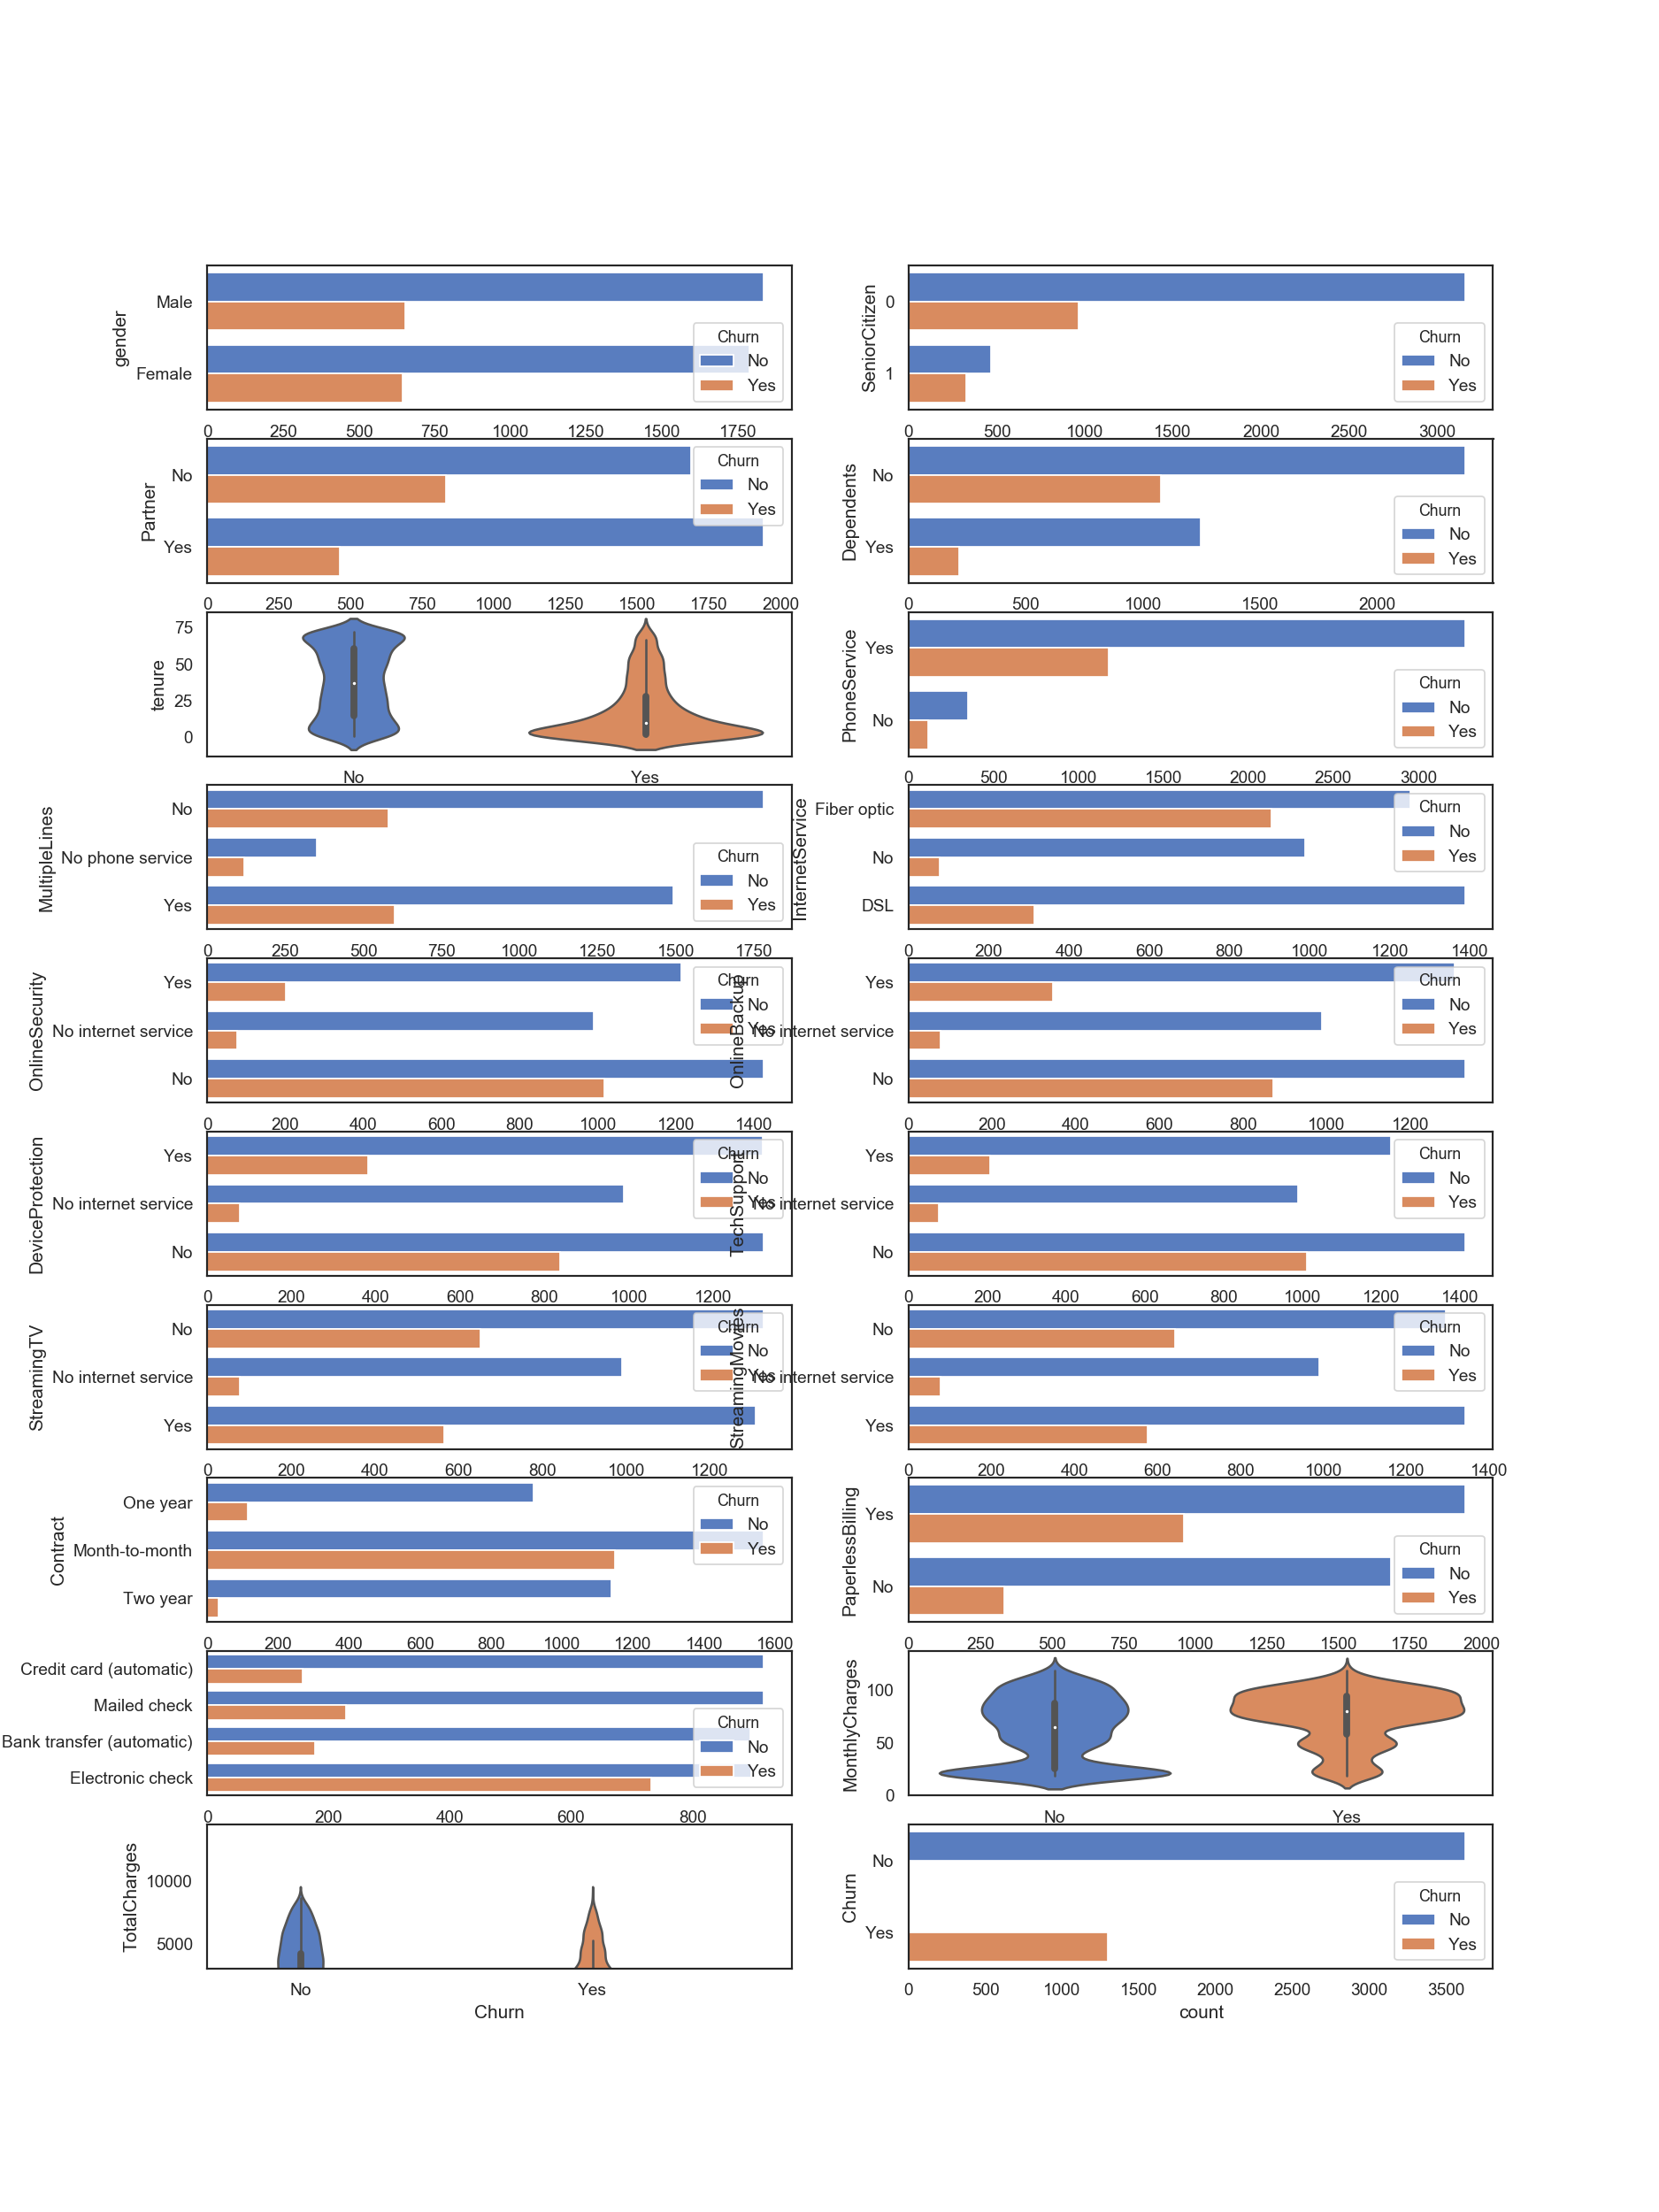

In [10]:
sns.set(style="white", palette="muted", color_codes=True)
# Set up the matplotlib figure
f, axes = plt.subplots(10, 2, figsize=(15, 20), sharex=False)
for i in range(10):
    for j in range(2):
        if columnNames[i*2+j] in ['tenure','MonthlyCharges','TotalCharges']:
            sns.violinplot(x='Churn', y = columnNames[i*2+j], data=churn_train,ax = axes[i,j])
        else:
            sns.countplot(y = columnNames[i*2+j],hue = "Churn", data=churn_train,ax = axes[i,j])


Observations:

Churning happens more on : high monthly charge,not senior citizen, no dependents,lower tenure, better phone service and internet, more e-commerce-based, on a monthly plan, and have less access to customer services.

# Question 2
Some observations from the plots:

**The gender does not matter**

**The "No internet" part in individual attributes is useless because the group with no internet is small**

**Only three attributes are not categorical**

Therefore, we modify the dataset:


In [21]:
churn_dummies = pd.get_dummies(churn,columns = [ 'SeniorCitizen', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn'])

Since columns are complements of each other, without loss of information,we can drop the following columns:

For example, if SeniorCitizen_0 = 0, then SeniorCitizen_1 would necessarily be 1; All the rest follows the same principle.

In [22]:
churn_dummies = churn_dummies.drop(['gender','customerID','MultipleLines_No phone service','OnlineSecurity_No internet service',
                                    'OnlineBackup_No internet service','DeviceProtection_No internet service',
                                    'TechSupport_No internet service', 'StreamingTV_No internet service',
                                    'StreamingMovies_No internet service','Churn_No','SeniorCitizen_0','Partner_No', 'Dependents_No',
                                   'PhoneService_No','MultipleLines_No','OnlineSecurity_No','OnlineBackup_No','DeviceProtection_No',
                                   'TechSupport_No', 'StreamingTV_No','StreamingMovies_No'], axis=1)

In [23]:
churn_dummies.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen_1',
       'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Churn_Yes'],
      dtype='object')

In [24]:
X = churn_dummies.drop(['Churn_Yes'],axis=1)
y = churn_dummies['Churn_Yes']
x_train, x_test, y_train, y_test = train_test_split(X,y.ravel(),test_size=0.30)

In [15]:
param_test = {
        'C':np.logspace(-3,0)
    }
estimator = LogisticRegression(solver='lbfgs',max_iter = 10000)
gsearch = GridSearchCV(estimator , param_grid = param_test, cv=10,scoring = 'neg_log_loss')
gsearch.fit(x_train,y_train)

print('best score is:',str(gsearch.best_score_))
print('best params are:',str(gsearch.best_params_))

best score is: -0.4203291370102861
best params are: {'C': 0.28117686979742307}


In [32]:
clf = LogisticRegression(C = 0.28117686979742307,solver='lbfgs',max_iter = 10000)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
log_loss(y_test,y_pred)

6.891447581536061

The train-test cross valiation returned optimal hyperparameter C to be 0.28117686979742307, 

and test it out on the test data returned cross-entropy loss of 6.891447581536061 

# Question 3

First, we would like to standardize all non-categorical values, so that Euclidian distance may be calculated more effectivly.

In [28]:
x_train_standard = x_train.copy()
x_train_standard[['tenure','MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(x_train[['tenure','MonthlyCharges','TotalCharges']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Then, we use gridsearch to identify which parameters are best for SVC. The hyperparameters tuned are: kernels, gamma, C and degree.

In [19]:
from sklearn.svm import SVC

param_test = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
                 {'kernel': ['poly'], 'degree': [2,3,4],
                     'C': [1, 10, 100, 1000]}]
estimator = SVC()
gsearch = GridSearchCV(estimator , param_grid = param_test, cv=10)
gsearch.fit(x_train_standard,y_train)

print('best score is:',str(gsearch.best_score_))
print('best params are:',str(gsearch.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

best score is: 0.8067858594067452
best params are: {'C': 10, 'degree': 3, 'kernel': 'poly'}


In [30]:
x_test_standard = x_test.copy()
x_test_standard[['tenure','MonthlyCharges','TotalCharges']] = StandardScaler().fit_transform(x_test[['tenure','MonthlyCharges','TotalCharges']])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
clf = SVC(C = 10, degree = 3, kernel = 'poly')
clf.fit(x_train_standard,y_train)
y_pred = clf.predict(x_test_standard)
log_loss(y_test,y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


7.136970264197755

The train-test cross valiation returned optimal hyperparameter:
    
C = 0.28117686979742307

degree = 3 

kernel = 'poly'

and testing it out on the test data returned cross-entropy loss of 7.136970264197755 

# Question 4

In [28]:
from sklearn.tree import DecisionTreeClassifier

param_test = {
    'max_depth':[3,4,5]
    }
estimator = DecisionTreeClassifier()
gsearch = GridSearchCV(estimator,param_grid = param_test, cv=10,scoring = 'neg_log_loss')
gsearch.fit(x_train,y_train)

print('best score is:',str(gsearch.best_score_))
print('best params are:',str(gsearch.best_params_))

best score is: -0.43174447371757224
best params are: {'max_depth': 4}


In [34]:
clf = DecisionTreeClassifier(max_depth = 4)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
log_loss(y_test,y_pred)

7.546221346904328

The train-test cross valiation returned optimal hyperparameter:
    
max_depth = 4

and testing it out on the test data returned cross-entropy loss of 7.546221346904328

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
param_test = {
    'n_estimators':[10,50,100,200],
    'max_depth':[3,4,5]
    }
estimator = RandomForestClassifier()
gsearch = GridSearchCV(estimator, param_grid = param_test, cv=10,scoring = 'neg_log_loss')
gsearch.fit(x_train,y_train)

print('best score is:',str(gsearch.best_score_))
print('best params are:',str(gsearch.best_params_))

best score is: -0.42172114259053356
best params are: {'max_depth': 5, 'n_estimators': 50}


In [35]:
clf = RandomForestClassifier(max_depth = 5, n_estimators = 50)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
log_loss(y_test,y_pred)

7.153336320887551

The train-test cross valiation returned optimal hyperparameter:
    
max_depth = 5

n_estimators = 50

and testing it out on the test data returned cross-entropy loss of 7.153336320887551

In [36]:
clf = GradientBoostingClassifier().fit(x_train, y_train)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
log_loss(y_test,y_pred)

7.006030063039419

testing GBDT out on the test data returned cross-entropy loss of 7.006030063039419

# Question 5

In general, logistic regression and GBDT returned relatively good results, both regarding training-testing set and validation set.

Logistic regression with l2 regularization tuned to the best hyperparameter gave the best results, and it is a rather simple algorithm, therefore I would recommend Logistic Regression.

SVC when dealing with categorical variables such as this dataset was very slow to compute. Therefore, I would not recommend this method.

Also, the data was processed to reduce as many dimensions as possible, but dimension is still very high. Some of my thoughts are: some variables may be correlated, and collinearity could affect the results.

My suggestions:

**Obtain more data. 7000 data with 20 dimensions doesn't have enough predictive power**

**With more data, I would prefer convolutional neural network with dropouts, so that we can better prevent overfitting**

**Use ensemble methods with Logistic regression to obtain better results**

**Reduce dimensions. But may cause the model to be less interpretable**